# Model

In [1]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from scipy.stats import uniform, randint
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
parquet_file = os.path.join(os.getcwd(), 'Data', 'Data_for_model.parquet')

try:
    merged_df = pd.read_parquet(parquet_file)
    print(merged_df.head(20))
except FileNotFoundError:
    print(f"File not found: {parquet_file}")
    print("Please check the path and ensure the file exists.")
except pd.errors.EmptyDataError as e:
    print(f"No data: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

print(merged_df.head())
print(merged_df.columns)

    movieID  customerID  rating  year       genres  runtime original_language   
0         1     1488844     3.0  2003  Documentary     50.0                en  \
1         1      822109     5.0  2003  Documentary     50.0                en   
2         1      885013     4.0  2003  Documentary     50.0                en   
3         1       30878     4.0  2003  Documentary     50.0                en   
4         1      823519     3.0  2003  Documentary     50.0                en   
5         1      893988     3.0  2003  Documentary     50.0                en   
6         1      124105     4.0  2003  Documentary     50.0                en   
7         1     1248029     3.0  2003  Documentary     50.0                en   
8         1     1842128     4.0  2003  Documentary     50.0                en   
9         1     2238063     3.0  2003  Documentary     50.0                en   
10        1     1503895     4.0  2003  Documentary     50.0                en   
11        1     2207774     

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21784674 entries, 0 to 21784673
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   movieID            int32  
 1   customerID         int32  
 2   rating             float64
 3   year               Int64  
 4   genres             object 
 5   runtime            float64
 6   original_language  object 
 7   popularity         float64
 8   adult              bool   
dtypes: Int64(1), bool(1), float64(3), int32(2), object(2)
memory usage: 1.2+ GB


In [4]:
merged_df.head()

,movieID,customerID,rating,year,genres,runtime,original_language,popularity,adult
0,1,1488844,3.0,2003,Documentary,50.0,en,0.581,False
1,1,822109,5.0,2003,Documentary,50.0,en,0.581,False
2,1,885013,4.0,2003,Documentary,50.0,en,0.581,False
3,1,30878,4.0,2003,Documentary,50.0,en,0.581,False
4,1,823519,3.0,2003,Documentary,50.0,en,0.581,False


In [5]:
merged_df['genres'].unique()

array(['Documentary', 'Horror, Mystery, Thriller', 'Horror',
       'Documentary, Comedy, Drama', 'Comedy, Horror, Science Fiction',
       'Drama, Crime', 'Comedy, Mystery, Romance',
       'Horror, Science Fiction, War', 'Action, Crime, Thriller',
       'Drama, Music, Romance', 'TV Movie, Action, Drama, Thriller',
       'Comedy, Romance, Adventure', 'Drama, Comedy', 'Comedy',
       'Action, Crime, Drama', 'Music, Comedy, Family',
       'Animation, Family', 'History, Drama, TV Movie',
       'Drama, Comedy, Romance', 'Documentary, Music', 'Drama, Romance',
       'Action, Drama', 'Drama', 'Drama, Action, Family', 'War',
       'Comedy, Drama', 'Comedy, Romance', 'Animation, Family, TV Movie',
       'Action, Adventure, Science Fiction', 'Music',
       'War, Drama, Romance', 'Thriller, Horror', 'Action, Thriller',
       'Drama, War', 'Fantasy, Action, Adventure, Drama',
       'War, Romance, Drama, Action, Adventure, Thriller',
       'Action, Adventure, Fantasy', 'Horror, Fantas

In [6]:
merged_df.duplicated().sum()

0

In [7]:
merged_df[(merged_df['rating'] < 1) | (merged_df['rating'] > 5)]

,movieID,customerID,rating,year,genres,runtime,original_language,popularity,adult


This filter is useful for cleaning the dataset by removing any invalid ratings that fall outside the expected range of 1 to 5.

In [8]:
movies_watched_per_customer = merged_df.groupby('customerID')['movieID'].nunique().reset_index()

movies_watched_per_customer.columns = ['customerID', 'movies_watched']

print(movies_watched_per_customer)

        customerID  movies_watched
0                6             134
1                7             181
2                8              21
3               10              46
4               25               4
...            ...             ...
469131     2649404              12
469132     2649409              10
469133     2649421               2
469134     2649426              70
469135     2649429              61

[469136 rows x 2 columns]


There are 469,136 rows in total, indicating the number of unique customers in the dataset.

In [9]:
label_encoder_customer = LabelEncoder()
label_encoder_movie = LabelEncoder()

merged_df['customerID'] = label_encoder_customer.fit_transform(merged_df['customerID'])
merged_df['movieID'] = label_encoder_movie.fit_transform(merged_df['movieID'])
merged_df

,movieID,customerID,rating,year,genres,runtime,original_language,popularity,adult
0,0,263866,3.0,2003,Documentary,50.0,en,0.581,False
1,0,146121,5.0,2003,Documentary,50.0,en,0.581,False
2,0,157192,4.0,2003,Documentary,50.0,en,0.581,False
3,0,5341,4.0,2003,Documentary,50.0,en,0.581,False
4,0,146359,3.0,2003,Documentary,50.0,en,0.581,False
...,...,...,...,...,...,...,...,...,...
21784669,3401,458888,2.0,2002,"Horror, Fantasy, War",97.0,tl,14.668,False
21784670,3401,317500,2.0,2002,"Horror, Fantasy, War",97.0,tl,14.668,False
21784671,3401,91101,5.0,2002,"Horror, Fantasy, War",97.0,tl,14.668,False
21784672,3401,175719,3.0,2002,"Horror, Fantasy, War",97.0,tl,14.668,False


Used `LabelEncoder` to convert categorical customer and movie IDs into numerical values, making the data suitable for machine learning algorithms.

In [10]:
label_encoders = {}
categorical_columns = ['genres', 'original_language']

for column in categorical_columns:
    le = LabelEncoder()
    merged_df[column] = le.fit_transform(merged_df[column])
    label_encoders[column] = le

In [11]:
new_df = merged_df.copy()

In [12]:
user_avg_rating = new_df.groupby('customerID')['rating'].mean().reset_index().rename(columns={'rating': 'user_avg_rating'})
user_num_ratings = new_df.groupby('customerID')['rating'].count().reset_index().rename(columns={'rating': 'user_num_ratings'})
new_df = pd.merge(new_df, user_avg_rating, on='customerID', how='left')
new_df = pd.merge(new_df, user_num_ratings, on='customerID', how='left')

movie_avg_rating = new_df.groupby('movieID')['rating'].mean().reset_index().rename(columns={'rating': 'movie_avg_rating'})
movie_num_ratings = new_df.groupby('movieID')['rating'].count().reset_index().rename(columns={'rating': 'movie_num_ratings'})
new_df = pd.merge(new_df, movie_avg_rating, on='movieID', how='left')
new_df = pd.merge(new_df, movie_num_ratings, on='movieID', how='left')

user_genre_rating = new_df.groupby(['customerID', 'genres'])['rating'].mean().reset_index().rename(columns={'rating': 'user_genre_rating'})
new_df = pd.merge(new_df, user_genre_rating, on=['customerID', 'genres'], how='left')

user_year_rating = new_df.groupby(['customerID', 'year'])['rating'].mean().reset_index().rename(columns={'rating': 'user_year_rating'})
new_df = pd.merge(new_df, user_year_rating, on=['customerID', 'year'], how='left')

`user_avg_rating`: The mean rating given by each user. This feature captures the general rating behavior of a user, indicating if they are typically a harsh or lenient rater.\
`user_num_ratings`: The total number of ratings given by each user. This feature indicates user engagement, as a higher number of ratings suggests a more active user.\
`movie_avg_rating`: The mean rating received by each movie. This feature reflects the general popularity or quality perception of a movie.\
`movie_num_ratings`: The total number of ratings a movie has received. This feature indicates the popularity or visibility of a movie.\
`user_genre_rating`: The mean rating given by each user for each genre. This feature captures the user’s preference for different genres, which can be crucial for personalized recommendations.\
`user_year_rating`: The mean rating given by each user for movies released in different years. This feature captures the user’s preference for movies from different years, which can be crucial for personalized recommendations

In [13]:
new_df['customerID'] = new_df['customerID'].astype(int)
new_df['movieID'] = new_df['movieID'].astype(int)
new_df['year'] = new_df['year'].astype(int)
new_df['runtime'] = new_df['runtime'].astype(float)
new_df['popularity'] = new_df['popularity'].astype(float)
new_df['user_avg_rating'] = new_df['user_avg_rating'].astype(float)
new_df['user_num_ratings'] = new_df['user_num_ratings'].astype(int)
new_df['movie_avg_rating'] = new_df['movie_avg_rating'].astype(float)
new_df['movie_num_ratings'] = new_df['movie_num_ratings'].astype(int)
new_df['user_genre_rating'] = new_df['user_genre_rating'].astype(float)
new_df['user_year_rating'] = new_df['user_year_rating'].astype(float)

Ensure data types.

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21784674 entries, 0 to 21784673
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   movieID            int32  
 1   customerID         int32  
 2   rating             float64
 3   year               int32  
 4   genres             int32  
 5   runtime            float64
 6   original_language  int32  
 7   popularity         float64
 8   user_avg_rating    float64
 9   user_num_ratings   int32  
 10  movie_avg_rating   float64
 11  movie_num_ratings  int32  
 12  user_genre_rating  float64
 13  user_year_rating   float64
dtypes: float64(7), int32(7)
memory usage: 1.7 GB


In [ ]:
new_df.to_parquet('Data/Data_for_recommendations.parquet', index=False)

This new data set `Data_for_recommendations` will be used later on in docker for to make recommendations for users.

In [16]:
sample_df = new_df.sample(frac=0.1, random_state=42)

Due to many tests and computer incapability to make handle whole data set been decided to use fraction of 10%, random selected data.

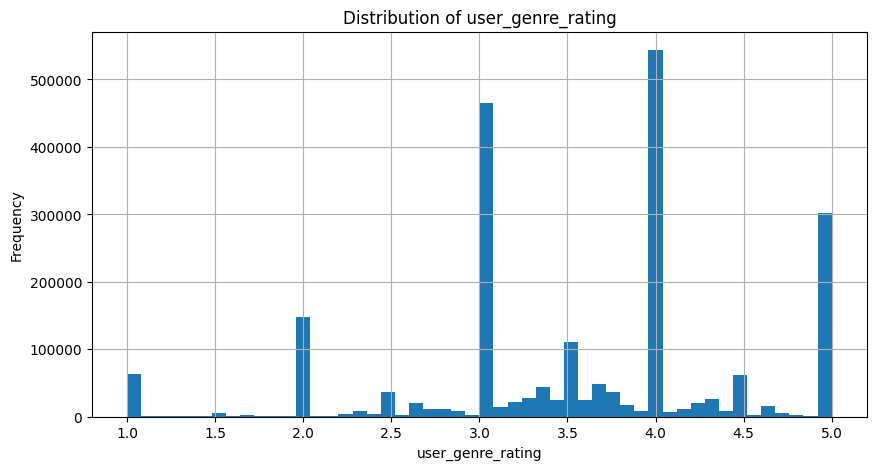

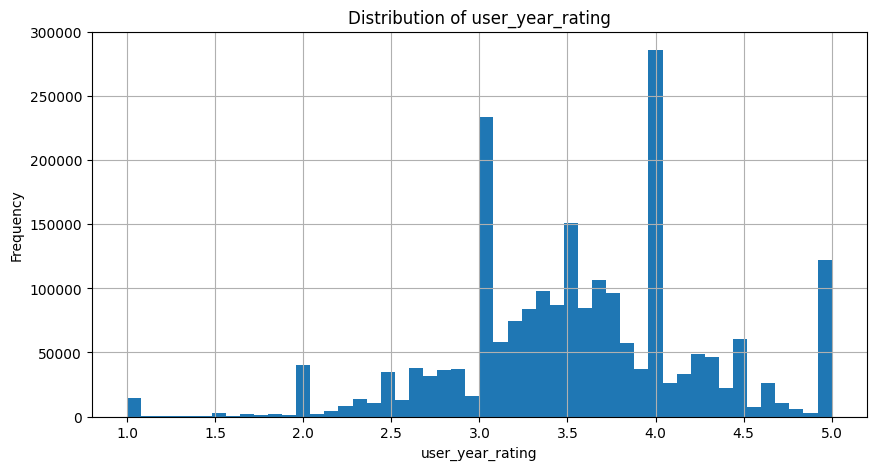

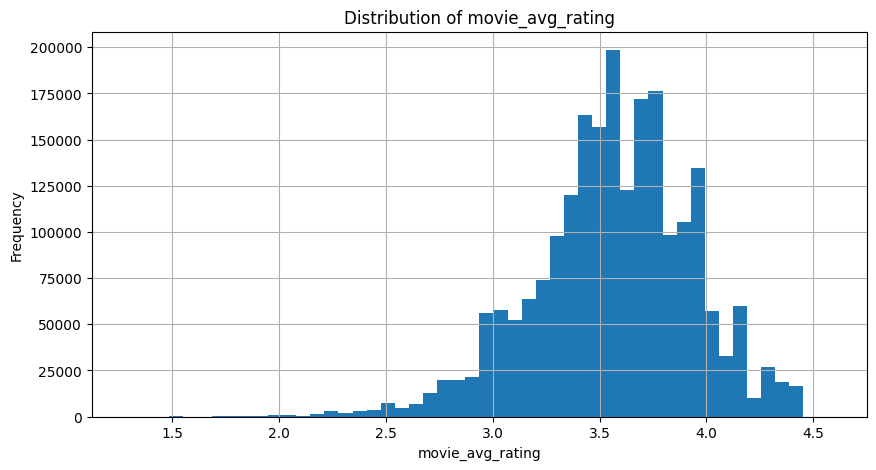

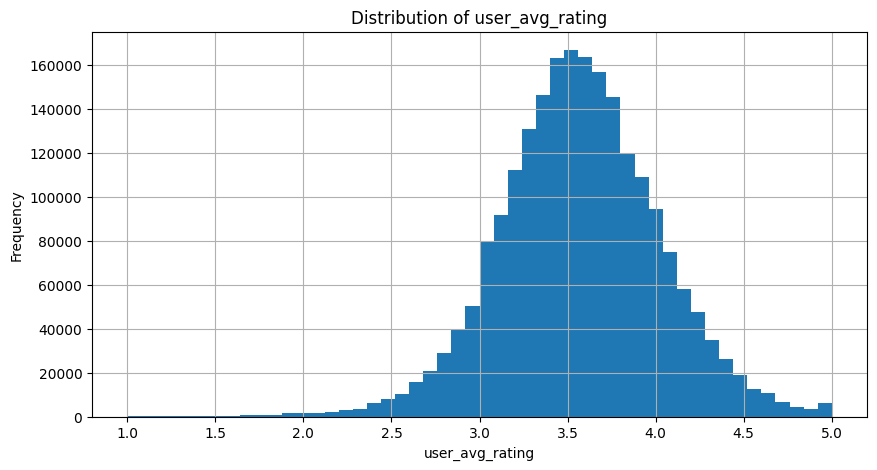

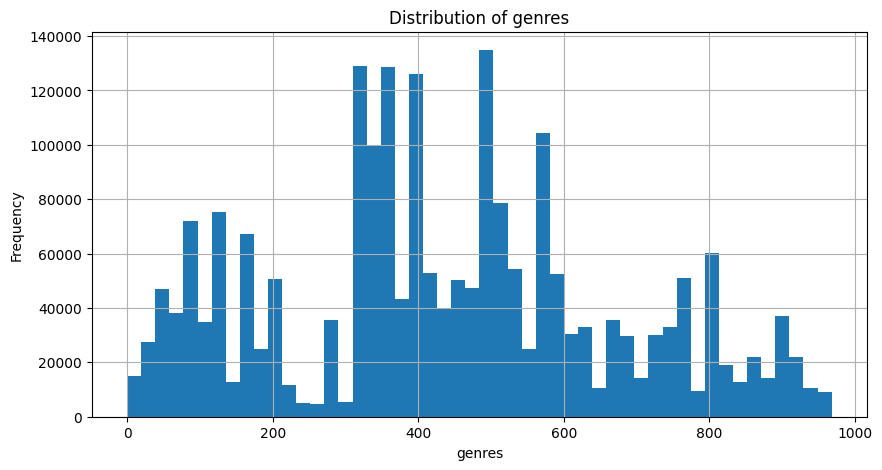

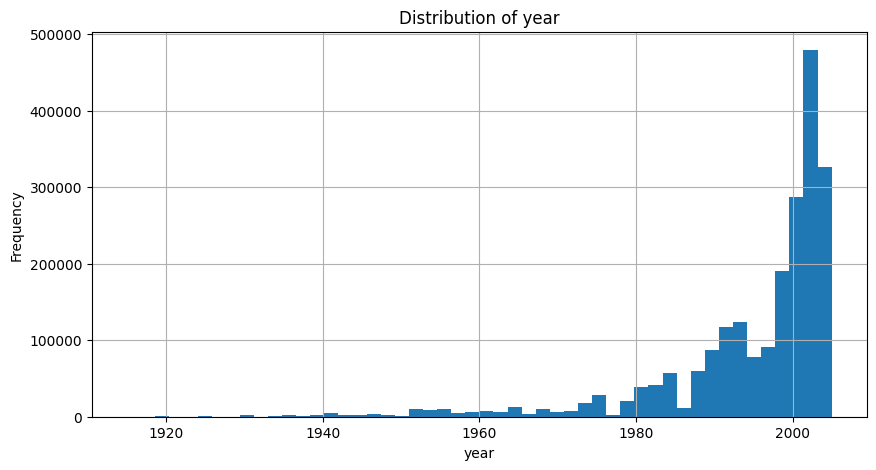

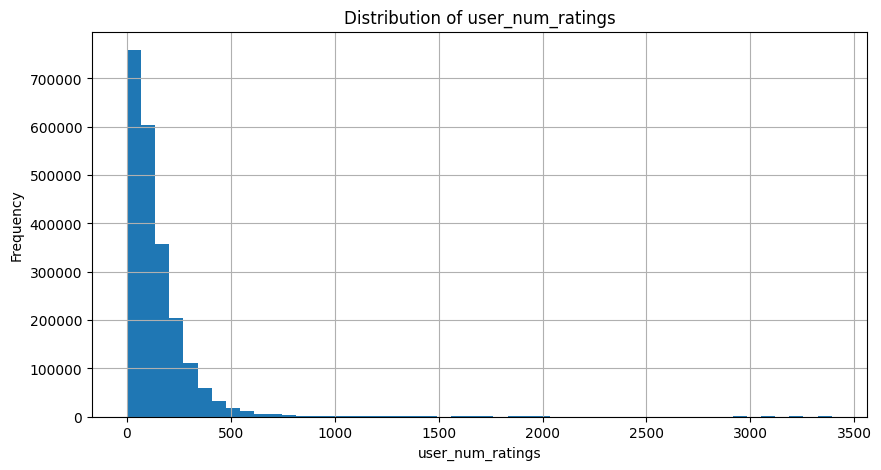

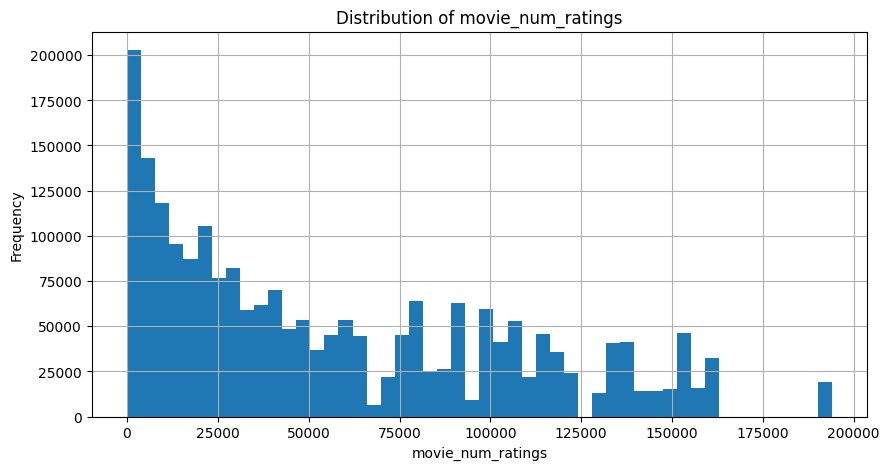

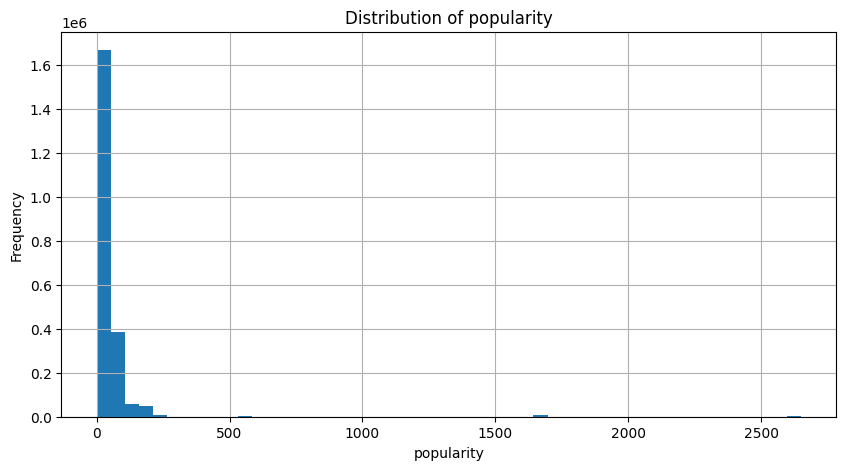

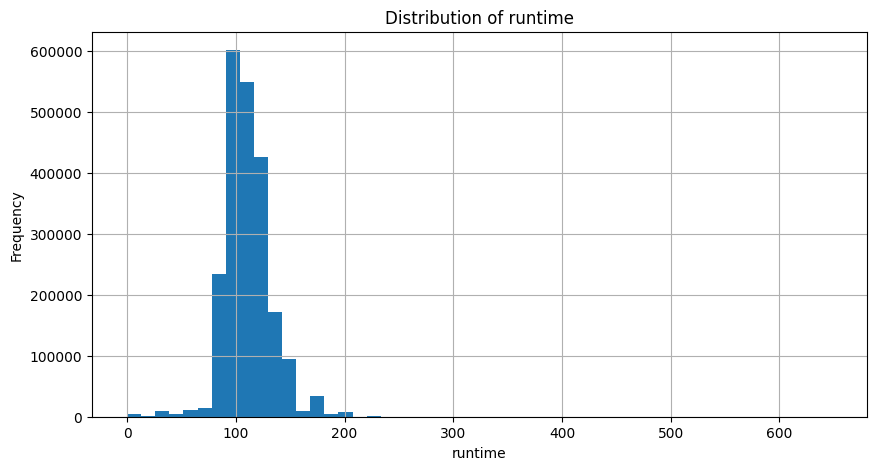

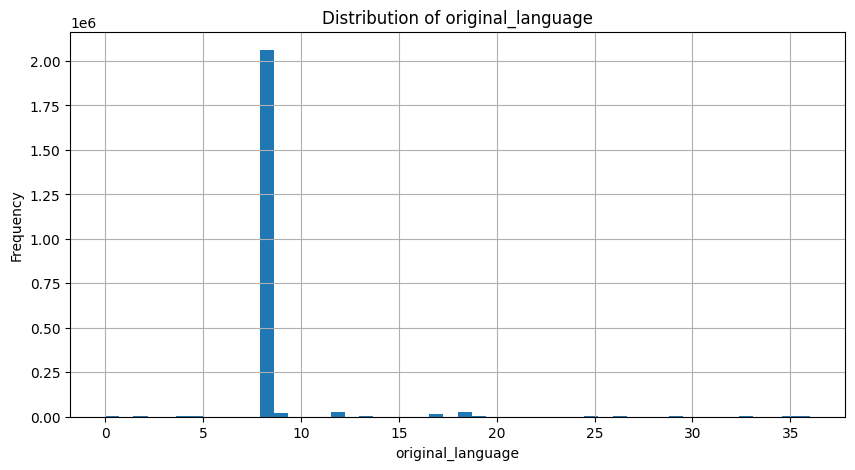

In [29]:
key_features = ['user_genre_rating', 'user_year_rating', 'movie_avg_rating', 
                'user_avg_rating', 'genres', 'year', 'user_num_ratings', 
                'movie_num_ratings', 'popularity', 'runtime', 'original_language']

for feature in key_features:
    plt.figure(figsize=(10, 5))
    sample_df[feature].hist(bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

We are able to see that some of features are not normal distributed due to some of them being categorical data.

### Focus - ratings predictions

All model will be trying to predict how user would rate certain movies and based on it recommend the ones which user would rate high.

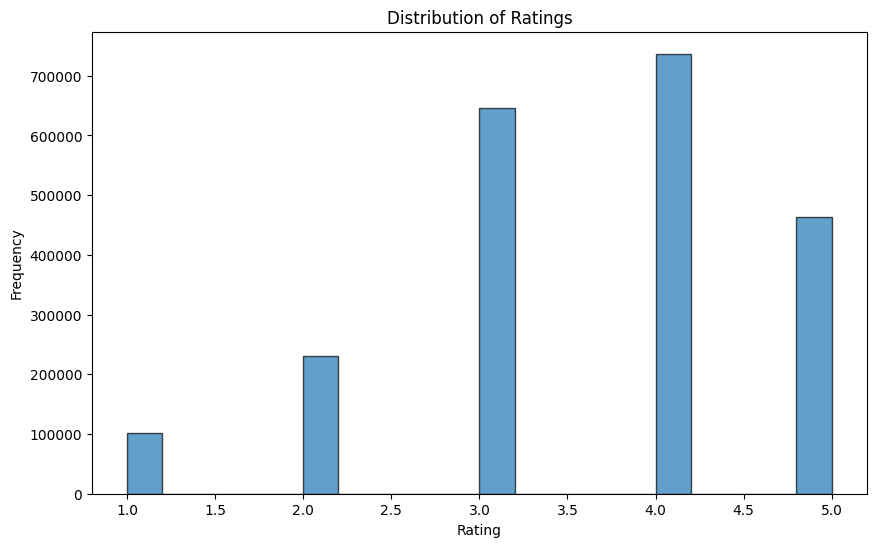

count    2.178467e+06
mean     3.565435e+00
std      1.077771e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [25]:
plt.figure(figsize=(10, 6))
plt.hist(sample_df['rating'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

print(sample_df['rating'].describe())

We are able to see that most of the features are skewed. So we are going to use log transformations on some continuous features.
Moreover, we can see imbalanced in `rating` feature which one we are targeting. For this later on we will look at metrics like: Precision, Recall, F1-score and AUC-ROC.

In [17]:
features = [
    'user_genre_rating', 'user_year_rating', 'movie_avg_rating', 
    'user_avg_rating', 'genres', 'year', 'user_num_ratings', 
    'movie_num_ratings', 'popularity', 'runtime', 'original_language']

X = sample_df[features]
y = sample_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train['user_num_ratings'] = np.log1p(X_train['user_num_ratings'])
X_train['movie_num_ratings'] = np.log1p(X_train['movie_num_ratings'])
X_train['popularity'] = np.log1p(X['popularity'])

To handle the skewed distributions of features, log transformations have been applied to certain numeric features. Additionally, this transformation has been applied only to the training dataset, with the assumption that raw data should be used for the test dataset to better evaluate model.

### VIF
Variance Inflation Factor (VIF) is a measure used to detect multicollinearity in a set of multiple regression variables.

In [20]:
numerical_features = ['user_genre_rating', 'user_year_rating', 'movie_avg_rating', 
                      'user_avg_rating', 'user_num_ratings', 'movie_num_ratings', 
                      'popularity', 'runtime']

a = X_train[numerical_features]
a['Intercept'] = 1 

vif_data = pd.DataFrame()
vif_data['Feature'] = a.columns
vif_data['VIF'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]

vif_data = vif_data[vif_data['Feature'] != 'Intercept']

print(vif_data)

C:\Users\pelec\AppData\Local\Temp\ipykernel_11168\3506890521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['Intercept'] = 1


             Feature       VIF
0  user_genre_rating  1.846201
1   user_year_rating  2.257091
2   movie_avg_rating  1.432656
3    user_avg_rating  1.820214
4   user_num_ratings  1.111419
5  movie_num_ratings  1.560198
6         popularity  1.354150
7            runtime  1.182366


Features have a moderate VIF values, indicating low to moderate multicollinearity with other features.

### Cross-validation
Cross-validation prevent from overfitting by splitting the data into multiple folds and training the model on different subsets, cross-validation helps ensure that the model generalizes well to unseen data. The model training stops if the validation scores do not improve for a certain number of rounds (early stopping). This prevents overfitting by stopping training once the model stops learning useful patterns from the data.

In [22]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

cv_results = lgb.cv(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1
    },
    train_set=train_data,
    num_boost_round=100,
    nfold=5,
    stratified=False,
    shuffle=True,
    callbacks=[
        lgb.early_stopping(stopping_rounds=10)
    ],
    seed=42
)

print(cv_results)

if 'valid rmse-mean' in cv_results:
    print(f"Cross-validation RMSE: {np.mean(cv_results['valid rmse-mean'])}")
else:
    print("Key 'valid rmse-mean' not found in cv_results.")

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	cv_agg's valid rmse: 0.449699 + 0.000644481
{'valid rmse-mean': [0.992829933551592, 0.9179735586469555, 0.8522946206127756, 0.7949550130460129, 0.7450762065062669, 0.7018294109725629, 0.6645690951554566, 0.6324529015584135, 0.6050928983727799, 0.5817857880760178, 0.5620085245264735, 0.5453367151194829, 0.5312722086668801, 0.5194716821306264, 0.5095915861939954, 0.5012850470592943, 0.49433927826451224, 0.48854558931541414, 0.4836603601825339, 0.47958283891454173, 0.4761439276223699, 0.4732546542918608, 0.4707953871598196, 0.46871932257986015, 0.46696483245874426, 0.46545580188881674, 0.46417528973243166, 0.46303900217273436, 0.4620624995593423, 0.46122419330799885, 0.4604600802936398, 0.4598002807585562, 0.45922217444041163, 0.45869094015649237, 0.4582031641965828, 0.45776344560846055, 0.4573834966947091, 0.45702221686416405, 0.4566920795614685, 0.4563947184834922, 0.456101

We see that cross-validation do not meed early stop what is positive. Moreover we got pretty low average RMSE.
Cross-Validation RMSE: 0.48973524290246273

In [ ]:
param_dist = {
    'num_leaves': randint(20, 30),
    'learning_rate': uniform(0.01, 0.03),
    'n_estimators': randint(100, 200),
    'min_child_samples': randint(10, 20),
    'subsample': uniform(0.5, 0.3),
    'colsample_bytree': uniform(0.5, 0.3),
    'reg_alpha': uniform(0.0, 0.5),
    'reg_lambda': uniform(0.0, 0.5),
    'bagging_freq': randint(0, 10),
    'feature_fraction': uniform(0.5, 0.3)
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse', verbose=-1)
random_search = RandomizedSearchCV(gbm, param_distributions=param_dist, n_iter=50, scoring='neg_root_mean_squared_error', cv=3, random_state=42, n_jobs=-1, error_score='raise')
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'bagging_freq': 6, 'colsample_bytree': 0.656250278007747, 'feature_fraction': 0.7883516073048047, 'learning_rate': 0.03533601546034454, 'min_child_samples': 11, 'n_estimators': 152, 'num_leaves': 27, 'reg_alpha': 0.17837666334679464, 'reg_lambda': 0.14046725484369038, 'subsample': 0.6628088249474745}


Hyperparameter tuning is a crucial step in machine learning to optimize the model's performance. Due to lack of computer capabilities grid ranges been reduced.

In [23]:
categorical_features = ['genres', 'year', 'original_language']

### Model: lightGBM

LightGBM in this case its ability to handle complex features, has flexibility in feature engineering, and its advanced boosting mechanism that captures intricate patterns in the data.

In [28]:
def to_binary(predictions: np.ndarray, threshold: float = 3.5) -> np.ndarray:
    """
    Convert continuous predictions to binary labels based on a threshold.

    Args:
        predictions (np.ndarray): Continuous prediction values.
        threshold (float, optional): Threshold for converting to binary labels. Defaults to 3.5.

    Returns:
        np.ndarray: Binary labels (0 or 1).
    """
    return (predictions >= threshold).astype(int)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_features)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03533601546034454,
    'num_leaves': 27,
    'min_child_samples': 11,
    'subsample': 0.6628088249474745,
    'colsample_bytree': 0.656250278007747,
    'reg_alpha': 0.17837666334679464,
    'reg_lambda': 0.14046725484369038,
    'n_estimators': 152,
    'bagging_freq': 6,
    'feature_fraction': 0.7883516073048047,
    'verbose': -1
}

def log_evaluation(period: int = 10):
    """
    Create a callback that logs evaluation results every 'period' iterations.

    Args:
        period (int, optional): The period (number of iterations) between log outputs. Defaults to 10.

    Returns:
        Callable: A callback function to be used in LightGBM training.
    """
    def _callback(env):
        if period > 0 and env.iteration % period == 0:
            print(f"[{env.iteration}] training's rmse: {env.evaluation_result_list[0][2]:.5f}, valid's rmse: {env.evaluation_result_list[1][2]:.5f}")
    _callback.order = 10
    return _callback

start_time = time.time()
model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=152, callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ])
end_time = time.time()

print(f'Training completed in {end_time - start_time:.2f} seconds')

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

threshold = 3.5
y_train_binary = to_binary(y_train, threshold)
y_test_binary = to_binary(y_test, threshold)
y_pred_train_binary = to_binary(y_pred_train, threshold)
y_pred_test_binary = to_binary(y_pred_test, threshold)

precision = precision_score(y_test_binary, y_pred_test_binary)
recall = recall_score(y_test_binary, y_pred_test_binary)
f1 = f1_score(y_test_binary, y_pred_test_binary)
auc_roc = roc_auc_score(y_test_binary, y_pred_test_binary)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f'Final RMSE: {rmse:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1-score: {f1:.5f}')
print(f'AUC-ROC: {auc_roc:.5f}')

c:\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[0] training's rmse: 1.06009, valid's rmse: 1.05906
Training until validation scores don't improve for 10 rounds
[10] training's rmse: 0.81629, valid's rmse: 0.81618
[20] training's rmse: 0.66347, valid's rmse: 0.66413
[30] training's rmse: 0.58626, valid's rmse: 0.58734
[40] training's rmse: 0.54213, valid's rmse: 0.54375
[50] training's rmse: 0.50517, valid's rmse: 0.50700
[60] training's rmse: 0.48512, valid's rmse: 0.48719
[70] training's rmse: 0.47273, valid's rmse: 0.47488
[80] training's rmse: 0.46486, valid's rmse: 0.46713
[90] training's rmse: 0.46054, valid's rmse: 0.46291
[100] training's rmse: 0.45732, valid's rmse: 0.45975
[110] training's rmse: 0.45503, valid's rmse: 0.45762
[120] training's rmse: 0.45332, valid's rmse: 0.45610
[130] training's rmse: 0.45199, valid's rmse: 0.45513
[140] training's rmse: 0.45095, valid's rmse: 0.45433
[150] training's rmse: 0.44995, valid's rmse: 0.45379
Did not meet early stopping. Best iteration is:
[152]	training's rmse: 0.449866	valid_

The model demonstrates strong predictive performance across various metrics, indicating its effectiveness in predicting movie ratings. The low RMSE values on both training and validation sets, coupled with high precision, recall, F1-score, and AUC-ROC values, suggest that the model is well-tuned and generalizes well to unseen data.

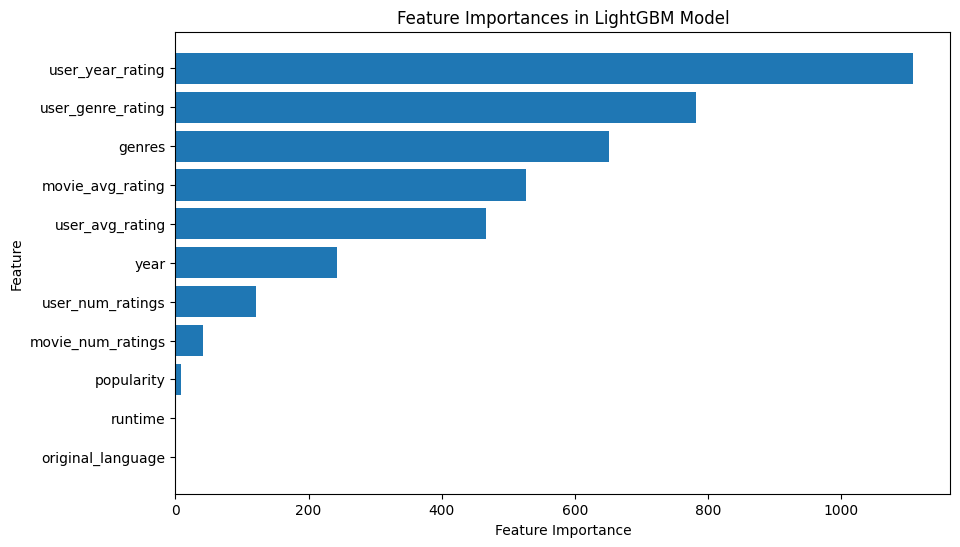

In [30]:
feature_importances = model.feature_importance()
feature_names = model.feature_name()

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in LightGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
model.save_model('Model/lightgbm_user_movie_recommendation.txt')